**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py # interact to H5 file
import scipy
from PIL import Image # Image
from scipy import ndimage # Image
from lr_utils import load_dataset

%matplotlib inline

## 2 - Overview of the Problem Set

In [2]:
# Load dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

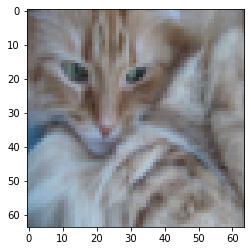

In [3]:
# Example of a picture
plt.imshow(train_set_x_orig[2])

In [4]:
# Find shape values
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print(m_train, m_test, num_px)

209 50 64


In [5]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print(train_set_x_flatten.shape)
print(train_set_y.shape)
print(test_set_x_flatten.shape)
print(test_set_y.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


In [6]:
# Standardize dataset (it is RGB data)
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## 3 - General Architecture of the Leargning Algorithm

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

## 4 - Building the Parts of our Algorithm

### 4.1 - Helper functions

In [7]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

### 4.2 - Initializing parameters
<code>np.zeros()</code>

In [8]:
def initialize_with_zeros(dim):
    '''
    Arguments
    dim = size of the w vector (number of parameters)
    ==================================================
    Returns
    w : initialized parameter (dim, 1)
    b : initialized bias
    '''
    w = np.zeros((dim,1))
    b = 0
    return w, b

### 4.3 - Forward and Backward propagation
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [9]:
def propagate(w, b, X, Y):
    '''
    Implement the cost function and its gradient for propagation
    ============================================================
    Arguments
    w : weights (num_px * num_px * 3, 1)
    b : bias
    X : data (num_px * num_px * 3, number of examples)
    Y : True label (1, number of examples)
    ============================================================
    Returns
    cost : negative log-likelihood
    dw : gradient of the loss with respect to w
    db : gradient of the loss with respect to b
    '''
    m = X.shape[1]

    # Forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1/m) * ( np.sum (Y * np.log(A) + (1-Y) * np.log(1-A)) )
    
    # Backward propagation
    dw = 1/m * np.dot(X, (A-Y).T)
    db = 1/m * np.sum(A-Y)
    
    cost = np.squeeze(cost)
    
    grads = {"dw":dw, "db":db}
    
    return grads, cost
    

### 4.4 - Optimization

In [10]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    '''
    ==========================================================
    Arguments
    w : weights
    b : bias
    X : data
    Y = true label
    num_iterations : number of iterations
    learning_rate : learning rate
    print_cost : True to print the loss every 100 steps
    ==========================================================
    Returns:
    params : dictionary containing w and b
    grads = dictionary containing dw and db
    costs = lists of all costs during optimization
    '''
    costs = []
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        
        # Update parameters
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record costs
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration %i : %f" %(i, cost))
        
    params = {'w':w, 'b':b}
    grads = {'dw':dw, 'db':db}
        
    return params, grads, costs

In [11]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    
    A = sigmoid(np.dot(w.T, X) + b)
    Y_prediction[:,] = np.where(A[:,] > 0.5, 1, 0)
    
    return Y_prediction

## 5 - Merge all Functions into a Model

In [12]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    # initialize parameters
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters
    w = parameters['w']
    b = parameters['b']
    
    # Predict train/test examples
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    acc_train = 1 - np.mean(np.abs(Y_prediction_train - Y_train))
    acc_test = 1 - np.mean(np.abs(Y_prediction_test - Y_test))
    print("train accuracy : {} %".format(acc_train * 100))
    print("test accuracy : {} %".format(acc_test * 100))
    
    d = {"costs" : costs,
         "Y_prediction_train" : Y_prediction_train,
         "Y_prediction_test" : Y_prediction_test,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations" : num_iterations}
    
    return d

In [13]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0 : 0.693147
Cost after iteration 100 : 0.584508
Cost after iteration 200 : 0.466949
Cost after iteration 300 : 0.376007
Cost after iteration 400 : 0.331463
Cost after iteration 500 : 0.303273
Cost after iteration 600 : 0.279880
Cost after iteration 700 : 0.260042
Cost after iteration 800 : 0.242941
Cost after iteration 900 : 0.228004
Cost after iteration 1000 : 0.214820
Cost after iteration 1100 : 0.203078
Cost after iteration 1200 : 0.192544
Cost after iteration 1300 : 0.183033
Cost after iteration 1400 : 0.174399
Cost after iteration 1500 : 0.166521
Cost after iteration 1600 : 0.159305
Cost after iteration 1700 : 0.152667
Cost after iteration 1800 : 0.146542
Cost after iteration 1900 : 0.140872
train accuracy : 99.04306220095694 %
test accuracy : 70.0 %


[[ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  1.  1.  0. -1.  0.  0.  0.  0.
   1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1.  0.  0.  1. -1.  0.
   0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  1.  0.  0.  0.]]


1.0

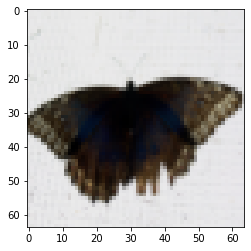

In [56]:
# Example of a picture that was wrongly classified.
print(test_set_y - np.squeeze(d["Y_prediction_test"])) # 5, 6, 10, 11, 13, ...
index = 13
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
np.squeeze(d["Y_prediction_test"])[index]

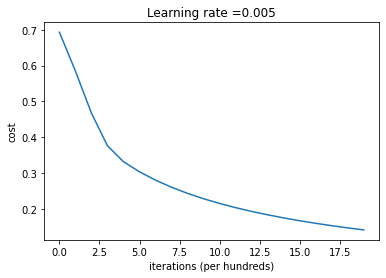

In [57]:
# Plot learning curve with costs
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Learning rate =' + str(d['learning_rate']))
plt.show()

## 6 - Further Analysis (optional/upgraded exercise)

learning rate is: 0.01
train accuracy : 99.52153110047847 %
test accuracy : 68.0 %
-------------------------------------------------------
learning rate is: 0.001
train accuracy : 88.99521531100478 %
test accuracy : 64.0 %
-------------------------------------------------------
learning rate is: 0.0001
train accuracy : 68.42105263157895 %
test accuracy : 36.0 %
-------------------------------------------------------


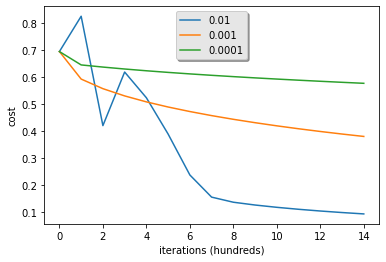

In [59]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ("-------------------------------------------------------")

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()